# Exploring possible oscillations in trimming distributions

In [1]:
library(data.table)
library(tidyverse)
library(cowplot)
options(repr.plot.width=12, repr.plot.height=9)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
data = fread('/fh/fast/matsen_e/shared/tcr-gwas/soto_alpha/vdjserver/pooled_processed.tsv')

## Are there trimming oscillations when we pool data from all joining genes and individuals?

In [3]:
pooled = data[v_trim <= 20 & productive == 'nonproductive', .N, by = .(v_gene, v_trim)]
pooled[, gene_count := sum(N), by = v_gene]
pooled[, freq := N/gene_count]
pooled[, gene_freq := gene_count/sum(N)]
pooled$type = 'all insertions'

In [4]:
pooled_no_insert = data[v_trim <= 20 & productive == 'nonproductive' & vj_insert == 0, .N, by = .(v_gene, v_trim)]
pooled_no_insert[, gene_count := sum(N), by = v_gene]
pooled_no_insert[, freq := N/gene_count]
pooled_no_insert[, gene_freq := gene_count/sum(N)]
pooled_no_insert$type = 'only zero insertions'

In [5]:
tog = rbind(pooled, pooled_no_insert)
tog$v_gene = factor(tog$v_gene, levels = unique(tog[type == 'all insertions'][order(-gene_freq)]$v_gene))

In [6]:
plot = ggplot(tog[gene_freq > 0.001]) +
    geom_line(aes(x = v_trim, y = freq, color = type, group = type), alpha = 0.9, linewidth = 1.5) +
    facet_wrap(~v_gene, ncol = 5) +
    xlab('Number of trimmed nucleotides')+
    ylab('Empirical trimming probability') +
    theme_cowplot(font_family = 'Arial') + 
    theme(text = element_text(size = 20), axis.text.x=element_text(size = 15), axis.text.y = element_text(size = 15), axis.line = element_blank(),axis.ticks = element_line(color = 'gray60', size = 1.5)) + 
    background_grid(major = 'xy') + 
    scale_color_viridis_d()+
    panel_border(color = 'gray60', size = 1.5)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


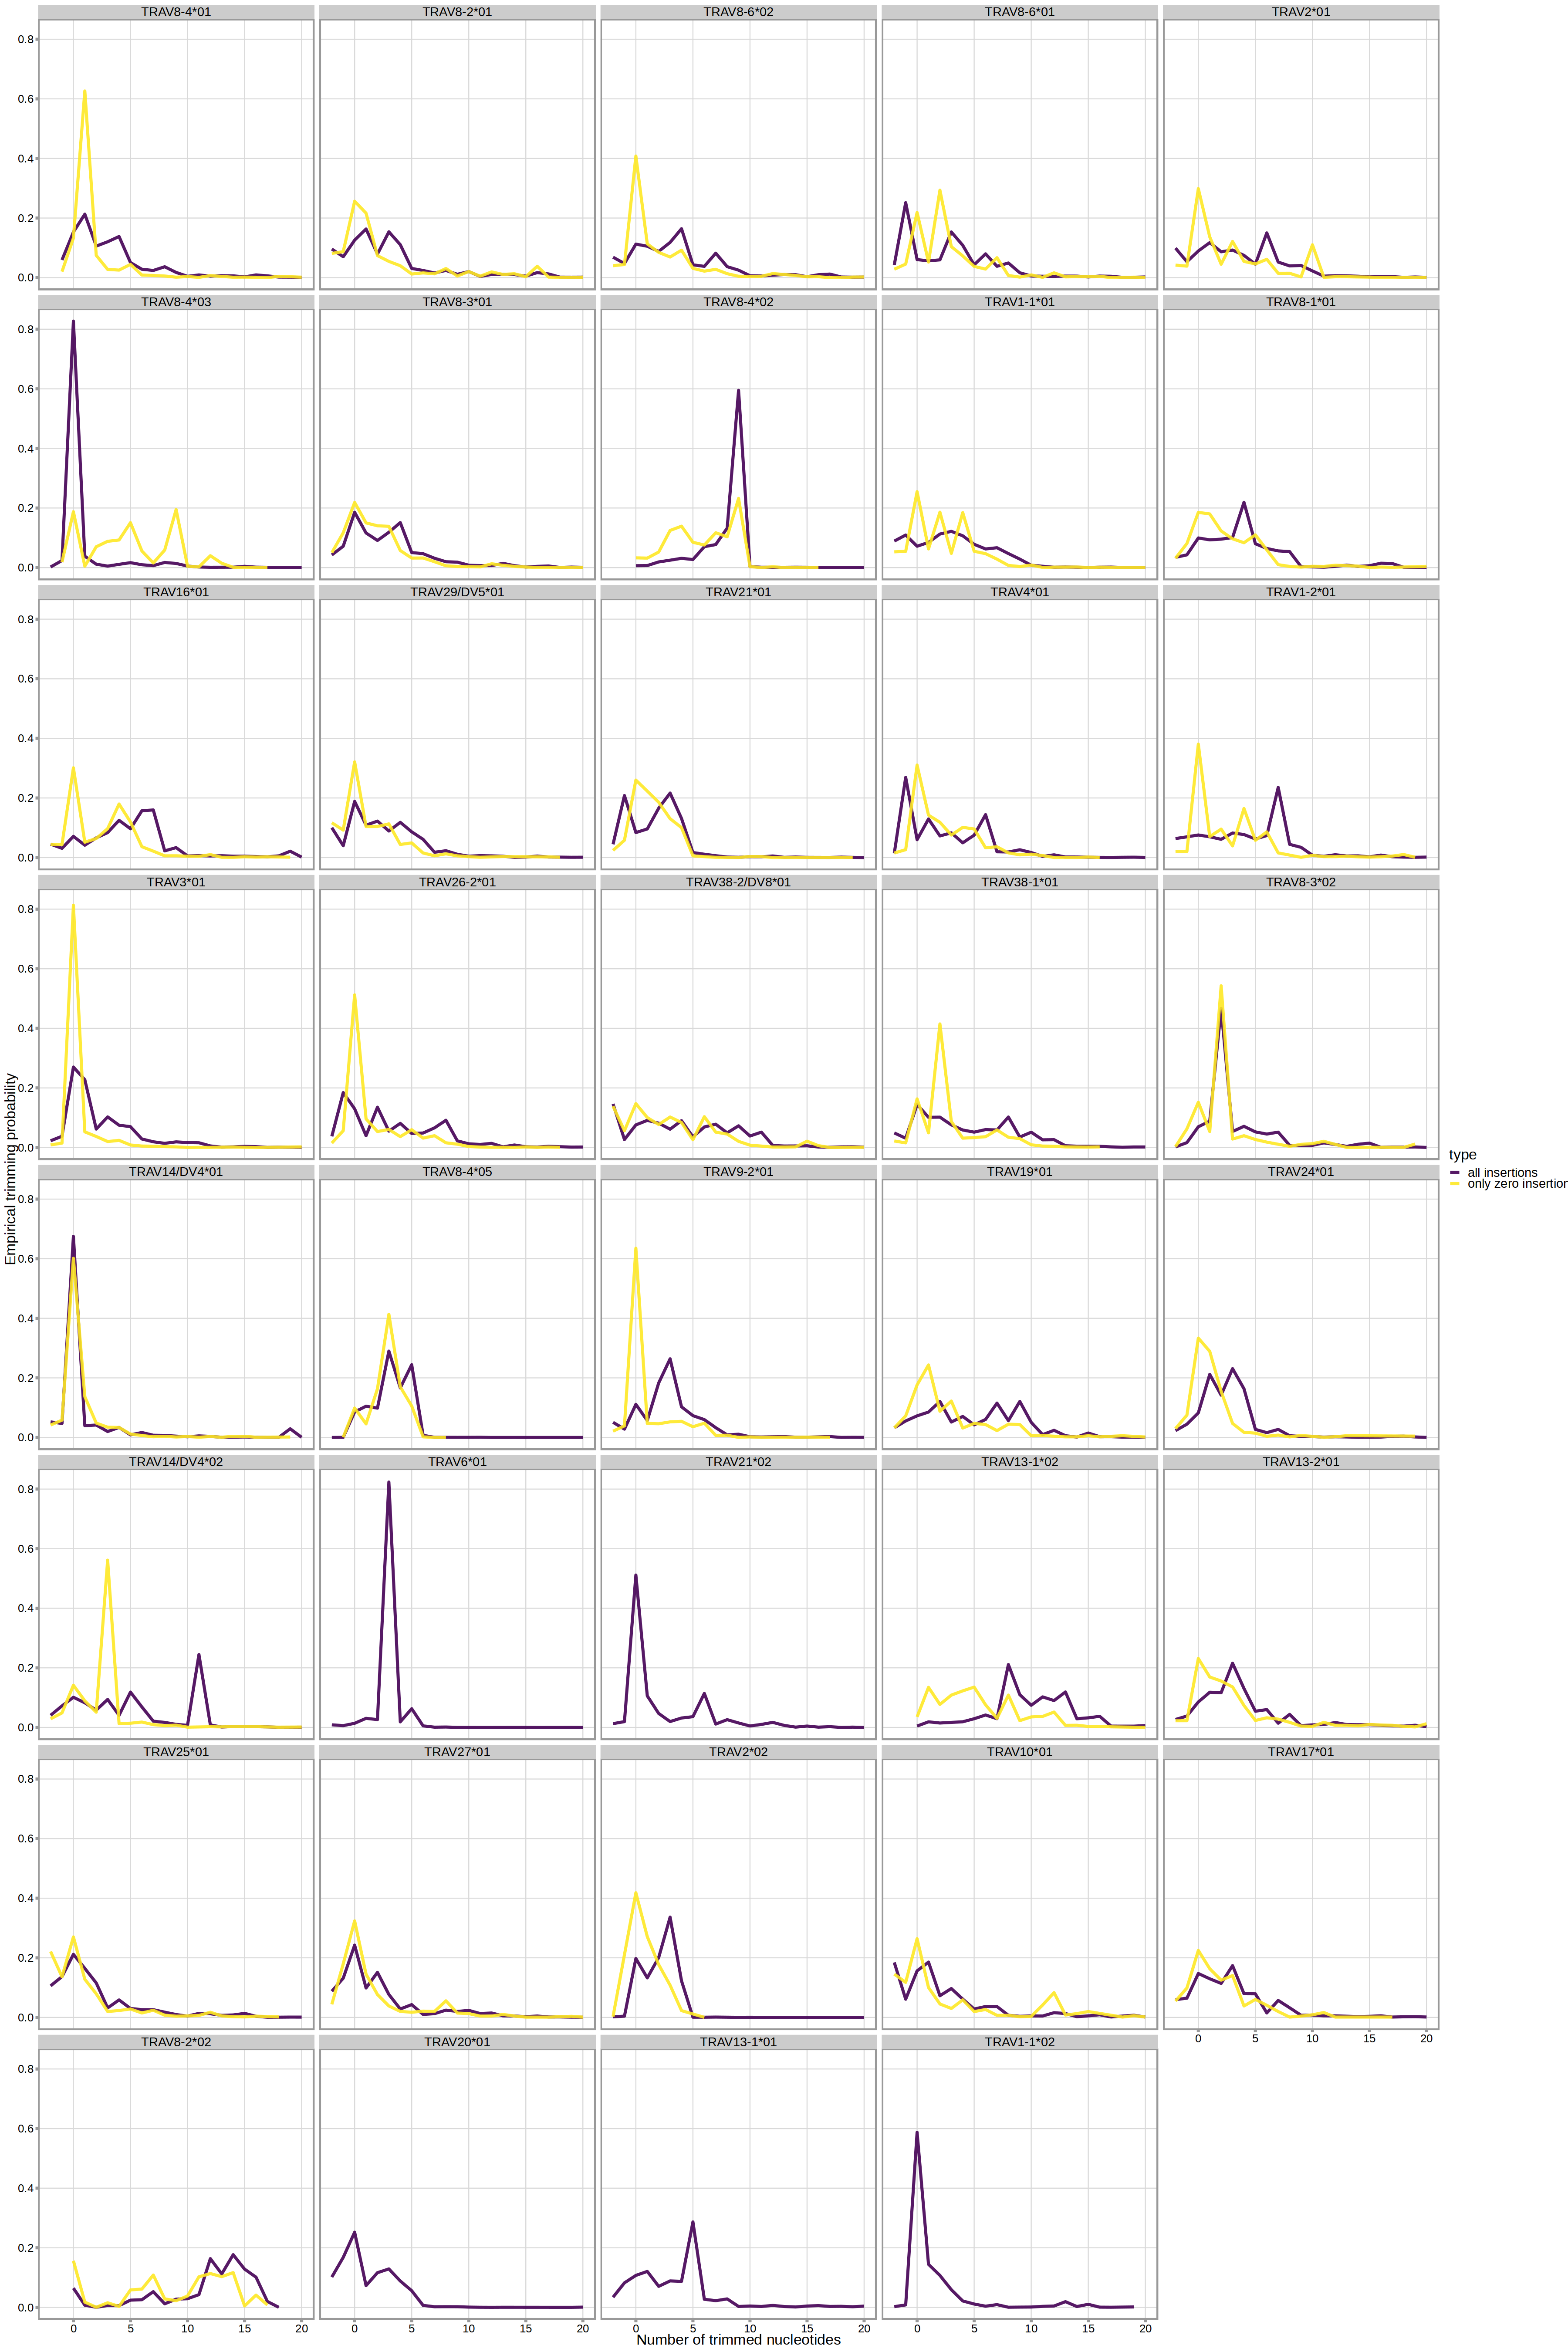

In [7]:
options(repr.plot.width=30, repr.plot.height=45)
plot

## Are there trimming oscillations when we pool data from all individuals, but split by joining gene?

In [8]:
split = data[v_trim <= 20 & productive == 'nonproductive', .N, by = .(v_gene, j_gene, v_trim)]
split[, gene_count := sum(N), by = v_gene]
split[, paired_count := sum(N), by = .(v_gene, j_gene)]
split[, freq := N/paired_count]
split[, gene_freq := gene_count/sum(N)]
split[, paired_freq := paired_count/sum(N)]
split$type = 'all insertions'
split$v_gene = factor(split$v_gene, levels = unique(split[order(-gene_freq)]$v_gene))


In [40]:
split_no_inserts = data[v_trim <= 20 & productive == 'nonproductive' & vj_insert == 0, .N, by = .(v_gene, j_gene, v_trim)]
nrow(split_no_inserts)
for (v in unique(split_no_inserts$v_gene)){
    for (j in unique(split_no_inserts$j_gene)){
        temp = split_no_inserts[v_gene == v & j_gene == j]
        if (nrow(temp) > 0){
            for (vt in seq(-2, 20)){
                temp2 = temp[v_trim == vt]
                if (nrow(temp2) < 1){
                    new = data.table(v_gene = v, j_gene = j, v_trim = vt, N = 0)
                    split_no_inserts = rbind(split_no_inserts, new)
                }
            }
        }
    }
}
nrow(split_no_inserts)
split_no_inserts[, gene_count := sum(N), by = v_gene]
split_no_inserts[, paired_count := sum(N), by = .(v_gene, j_gene)]
split_no_inserts[, freq := N/paired_count]
split_no_inserts[, gene_freq := gene_count/sum(N)]
split_no_inserts[, paired_freq := paired_count/sum(N)]
split_no_inserts$type = 'only zero insertions'
split_no_inserts$v_gene = factor(split_no_inserts$v_gene, levels = unique(split_no_inserts[order(-gene_freq)]$v_gene))

[1] 13784

[1] 61617

In [35]:
plot2 = ggplot(split[paired_freq > 0.001]) +
    geom_line(aes(x = v_trim, y = freq, group = j_gene), alpha = 0.4, linewidth = 1) +
    facet_wrap(~v_gene, ncol = 5) +
    xlab('Number of trimmed nucleotides')+
    ylab('Empirical trimming probability') +
    theme_cowplot(font_family = 'Arial') + 
    theme(text = element_text(size = 20), axis.text.x=element_text(size = 15), axis.text.y = element_text(size = 15), axis.line = element_blank(),axis.ticks = element_line(color = 'gray60', size = 1.5)) + 
    background_grid(major = 'xy') + 
    panel_border(color = 'gray60', size = 1.5)

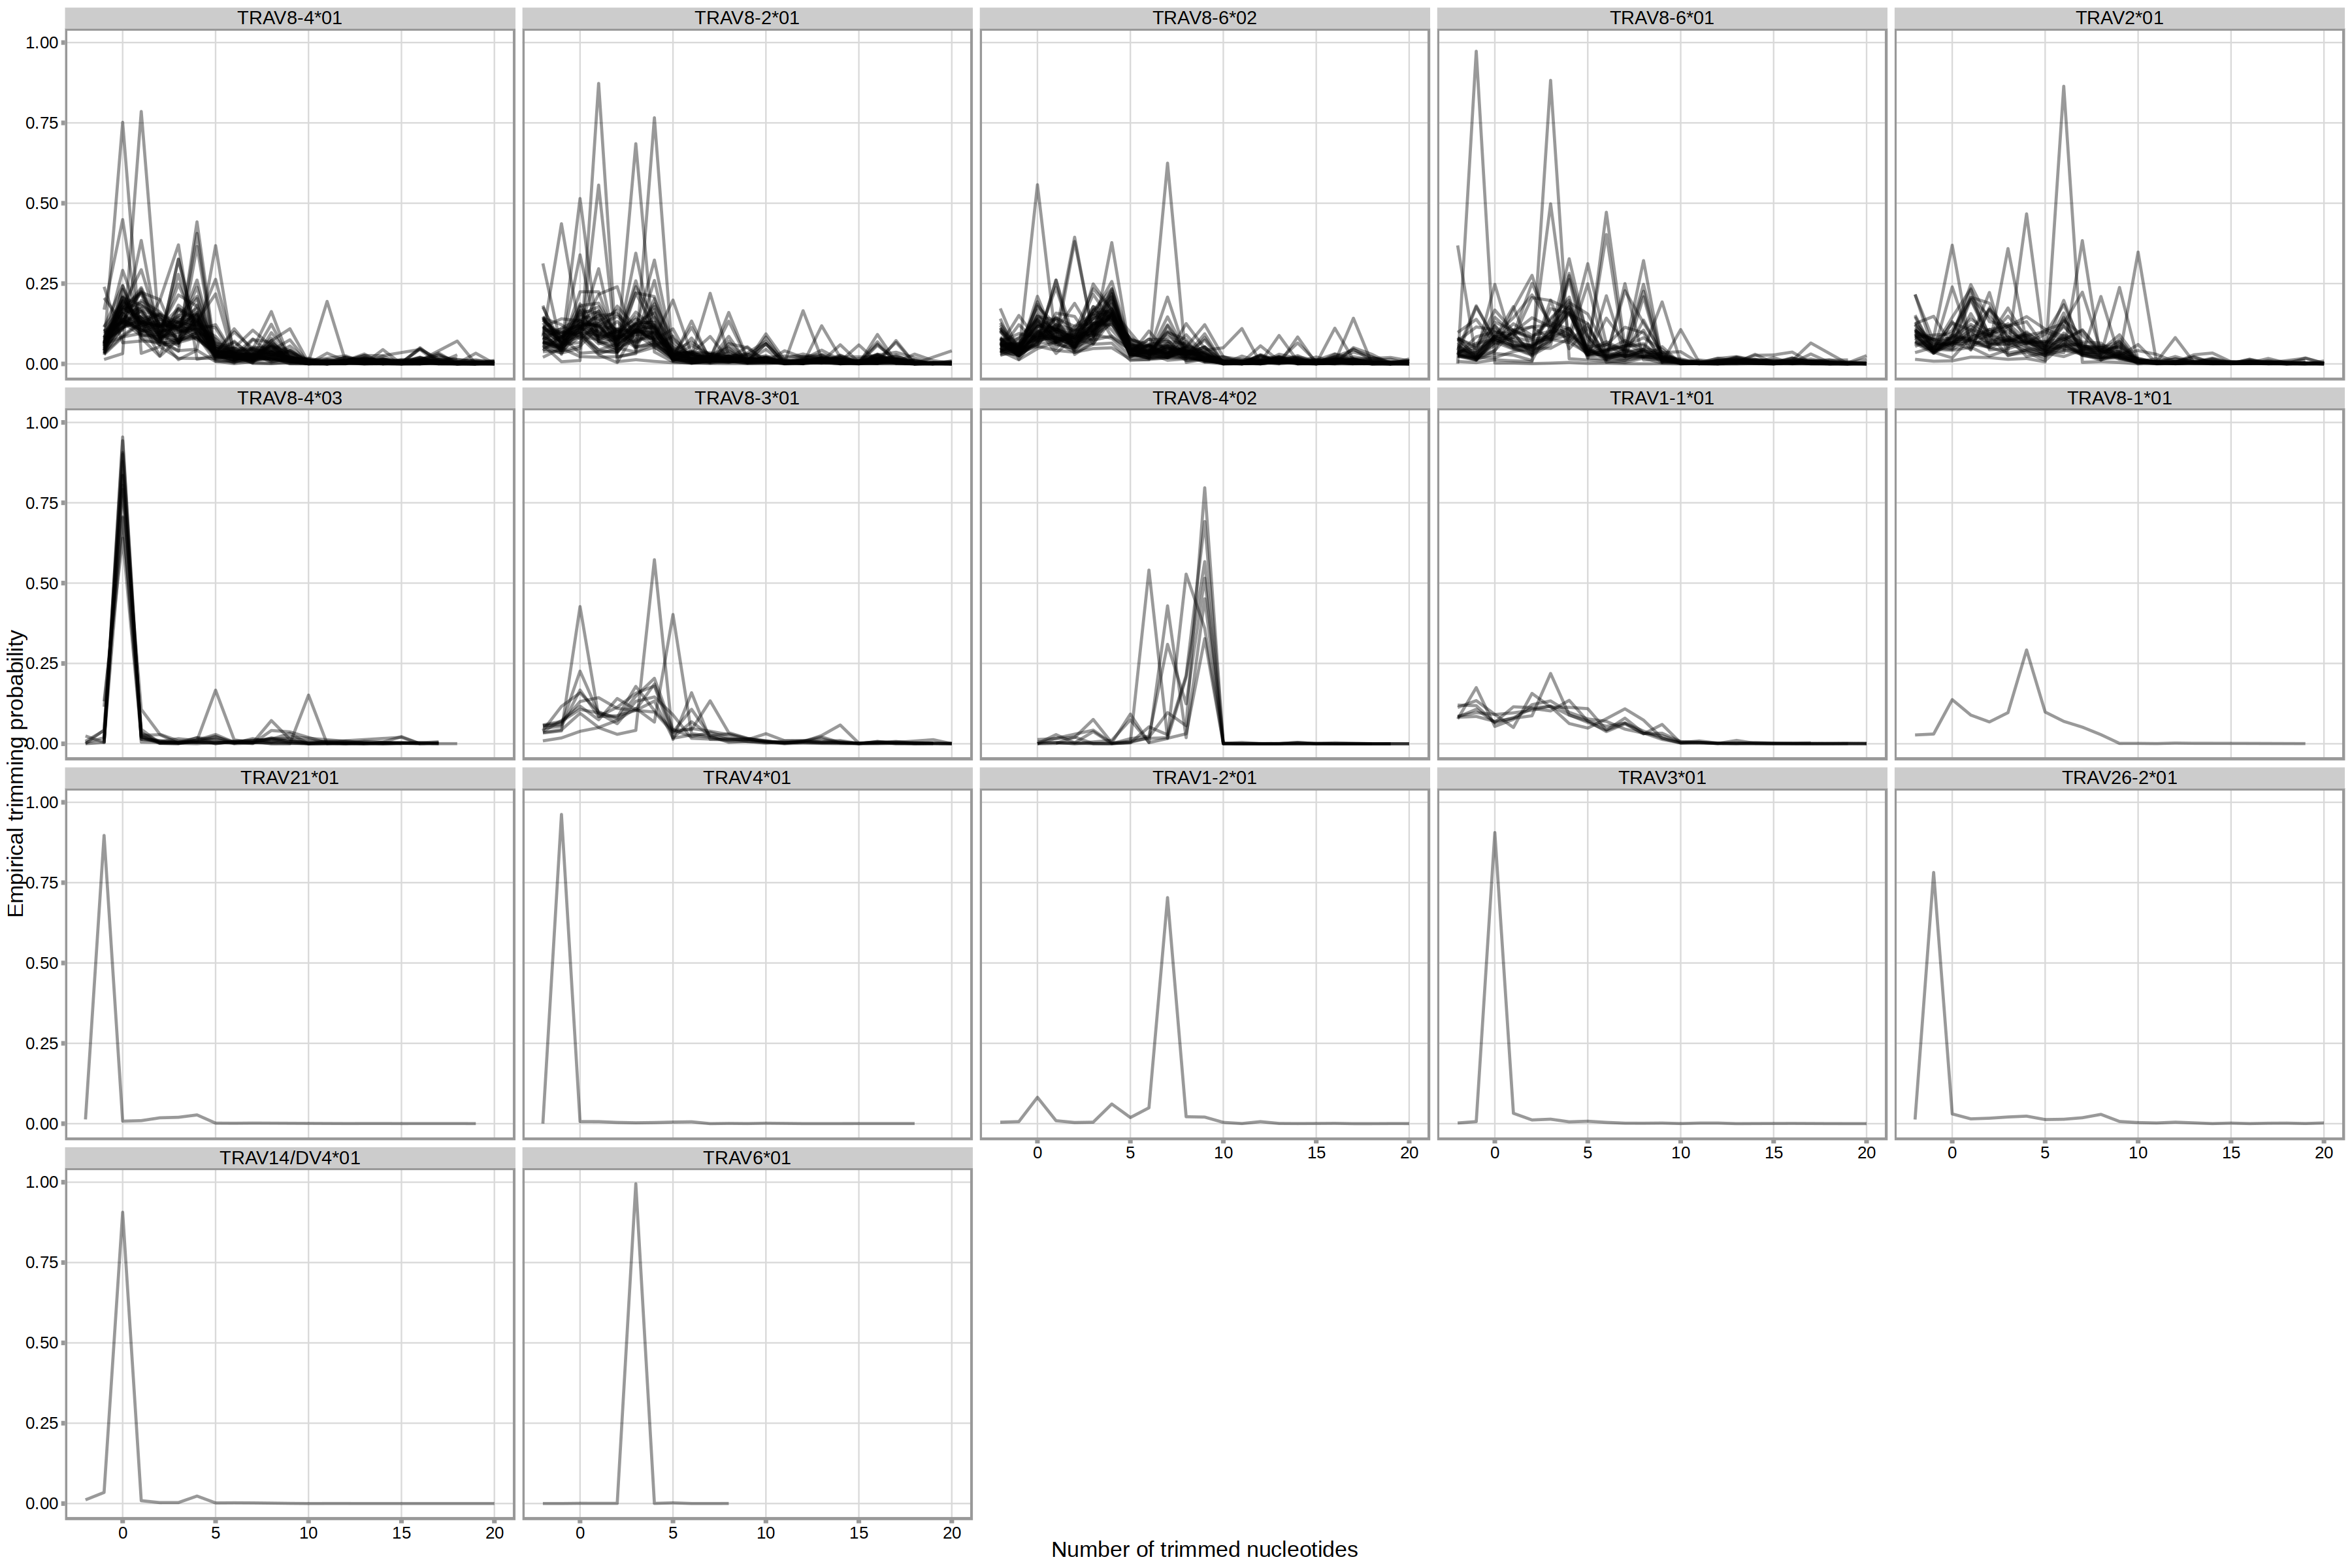

In [36]:
options(repr.plot.width=30, repr.plot.height=20)
plot2

In [43]:
plot3 = ggplot(split_no_inserts[paired_freq > 0.001]) +
    geom_line(aes(x = v_trim, y = freq, group = j_gene), alpha = 0.4, linewidth = 1) +
    facet_wrap(~v_gene, ncol = 5) +
    xlab('Number of trimmed nucleotides')+
    ylab('Empirical trimming probability') +
    theme_cowplot(font_family = 'Arial') + 
    theme(text = element_text(size = 20), axis.text.x=element_text(size = 15), axis.text.y = element_text(size = 15), axis.line = element_blank(),axis.ticks = element_line(color = 'gray60', size = 1.5)) + 
    background_grid(major = 'xy') + 
    scale_color_viridis_d()+
    panel_border(color = 'gray60', size = 1.5)

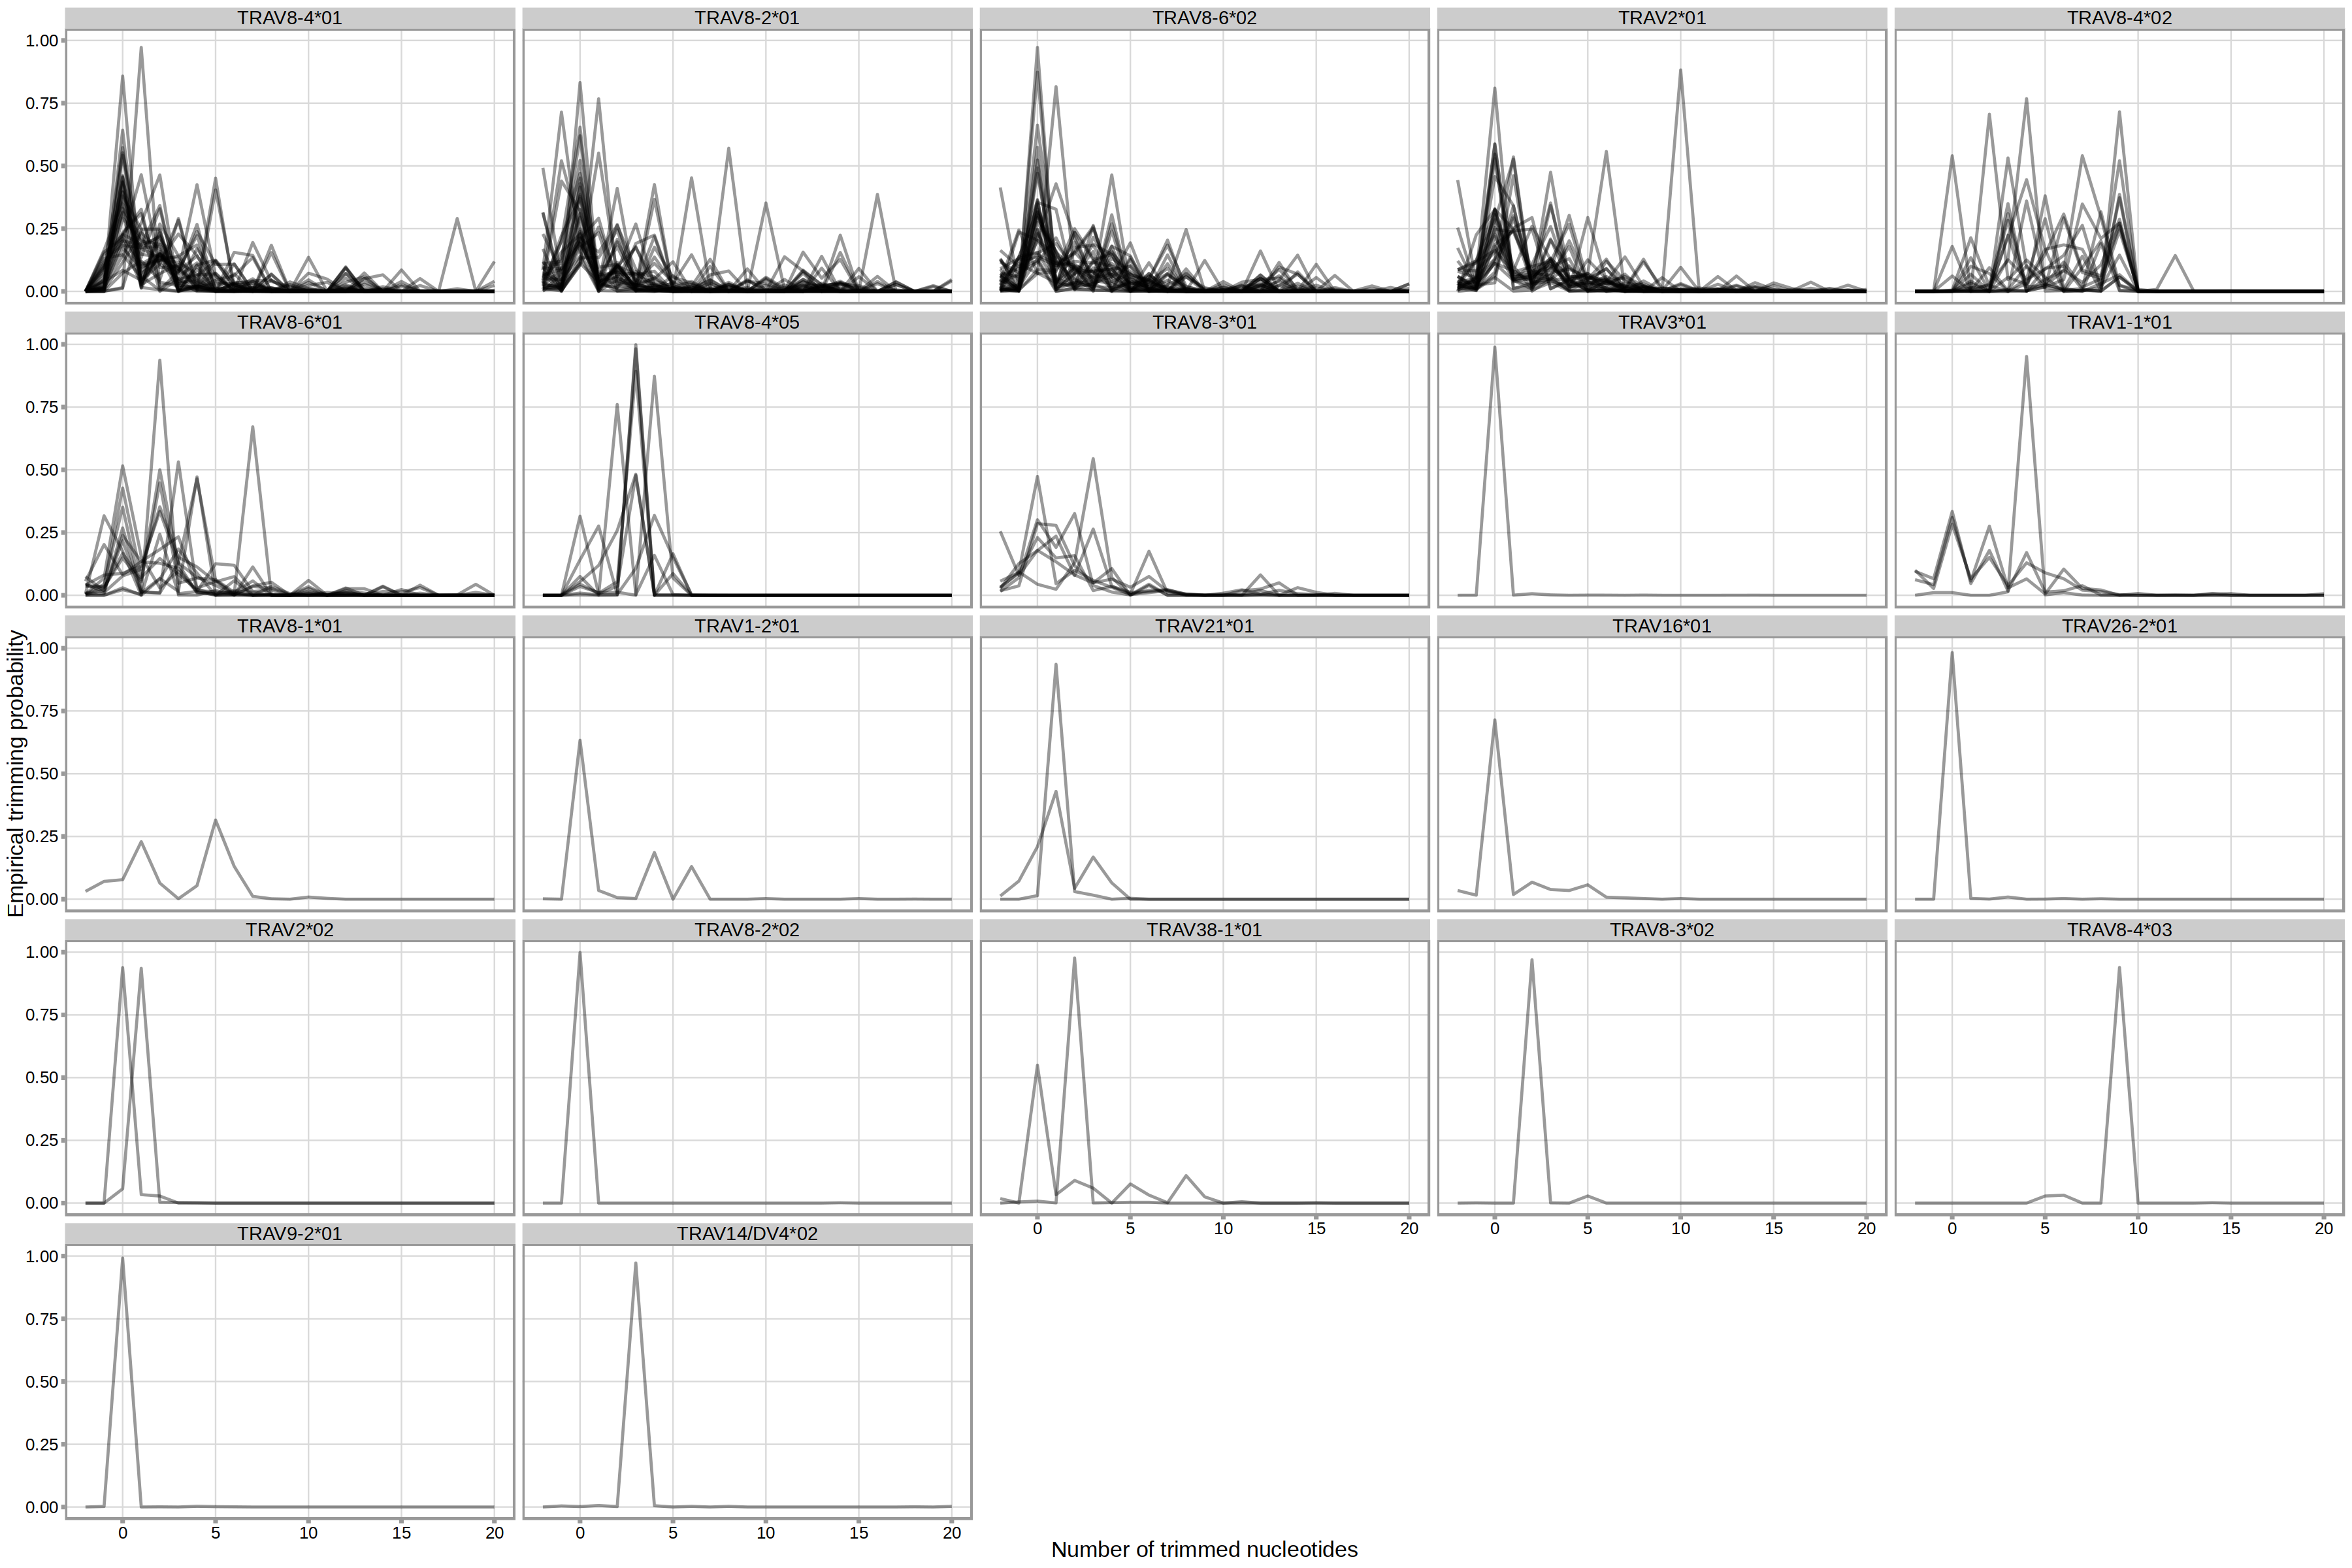

In [44]:
options(repr.plot.width=30, repr.plot.height=20)
plot3

In [30]:
sum(split$N)
sum(split_no_inserts$N)

[1] 6064068

[1] 552469